<a href="https://colab.research.google.com/github/shyamjith94/PyTorch/blob/main/MNISTHandWrittenDigit_DataClaasification_CNNnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
%%capture
!pip install torch torchvision

**Convolutional neural network**

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch, torchvision
import torch.nn as NN
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from torchvision.utils import make_grid

In [124]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [125]:
transform = transforms.ToTensor()

In [126]:
train_data = datasets.MNIST(root='/content/drive/MyDrive/PyTorch/Data/MNISTDownloadMe', train=True, download=True, transform=transform)

In [127]:
test_data = datasets.MNIST(root='/content/drive/MyDrive/PyTorch/Data/MNISTDownloadMe', train=False, download=True, transform=transform)

In [128]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/PyTorch/Data/MNISTDownloadMe
    Split: Train
    StandardTransform
Transform: ToTensor()

In [129]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/PyTorch/Data/MNISTDownloadMe
    Split: Test
    StandardTransform
Transform: ToTensor()

In [130]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [131]:
# 1 - one input chanel
# 6 - output chanel feature extraction(arbitory choice)
# 3 - 3 by 3 filter (keranal)
# 1 - stride(stepsize)
connv1 = NN.Conv2d(1,6,3,1)
# 6 came from first connv2d layer 
# 16 output chanel feature extraction(arbitory choice)
# 3 - 3 by 3 filter (keranal)
# 1 - stride(stepsize)
connv2 = NN.Conv2d(6, 16, 3, 1)

In [132]:
# taking one image
for i, (x_train, y_train) in enumerate(train_data):
    break

In [133]:
x_train.shape

torch.Size([1, 28, 28])

In [134]:
x_train.view(1,1,28,28).shape

torch.Size([1, 1, 28, 28])

In [135]:
x = x_train.view(1,1,28,28)

**pass to first layer**

In [136]:
x = F.relu(connv1(x))

In [137]:
x.shape
# 26 loosing borders original is 28,  add padding fix issue

torch.Size([1, 6, 26, 26])

**add max pool layer**

In [138]:
# 2 kernal
# 2 kernal
x = F.max_pool2d(x, 2, 2)

In [139]:
x.shape
# 13 half of 26
# 13 half of 26

torch.Size([1, 6, 13, 13])

**pass to secound layer**

In [140]:
x = F.relu(connv2(x))

In [141]:
# 11 loosing border pixel  from 13 pixel
# 11 loosing border pixel  from 13 pixel
x.shape

torch.Size([1, 16, 11, 11])

In [142]:
# 2 kernal
# 2 kernal
x = F.max_pool2d(x, 2,2)

In [143]:
x.shape
# 5 half of 11 rounding
# 5 half of 11 rounding

torch.Size([1, 16, 5, 5])

In [144]:
# final shape
x.view(-1, 16*5*5).shape

torch.Size([1, 400])

**Creating network Model**

In [145]:
class ConvolutionalNetwork(NN.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = NN.Conv2d(1, 6, 3, 1)
        self.conv2 = NN.Conv2d(6, 16, 3, 1)
        self.fc1 = NN.Linear(5*5*16, 120)
        self.fc2 = NN.Linear(120, 84)
        self.fc3 = NN.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [146]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [147]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [148]:
criterion = NN.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [149]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.48150820  accuracy:  78.400%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.11086808  accuracy:  85.333%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.01967988  accuracy:  88.511%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.09354196  accuracy:  90.254%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00180938  accuracy:  91.420%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.04877997  accuracy:  92.322%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.10025699  accuracy:  92.950%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00242361  accuracy:  93.423%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00265223  accuracy:  93.854%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.08694701  accuracy:  94.222%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.03828767  accuracy:  97.800%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00194439  accuracy:  97.842%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.04087923  accuracy:  97.911%
epoch:  1  b

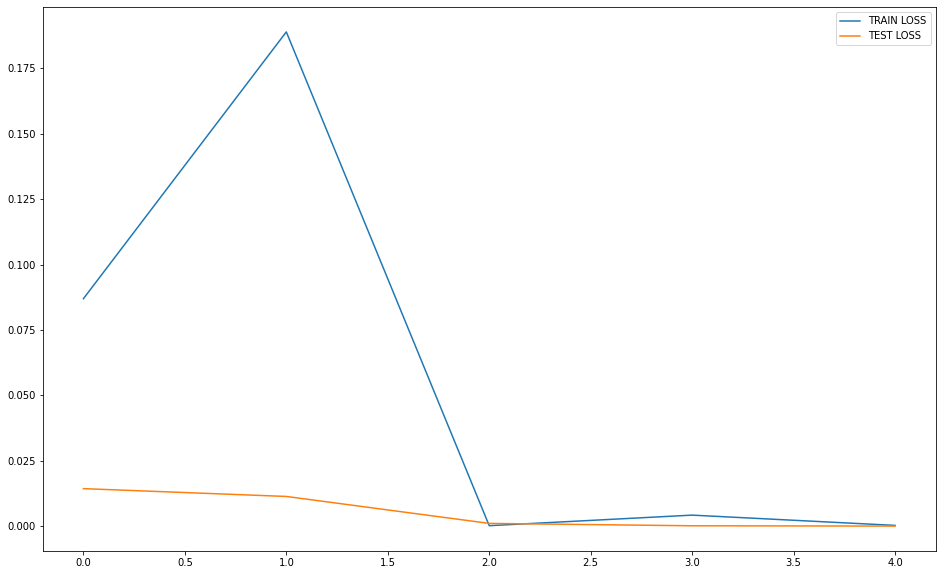

In [153]:
plt.figure(figsize=(16,10))
plt.plot(train_losses, label="TRAIN LOSS")
plt.plot(test_losses, label="TEST LOSS")
plt.legend()

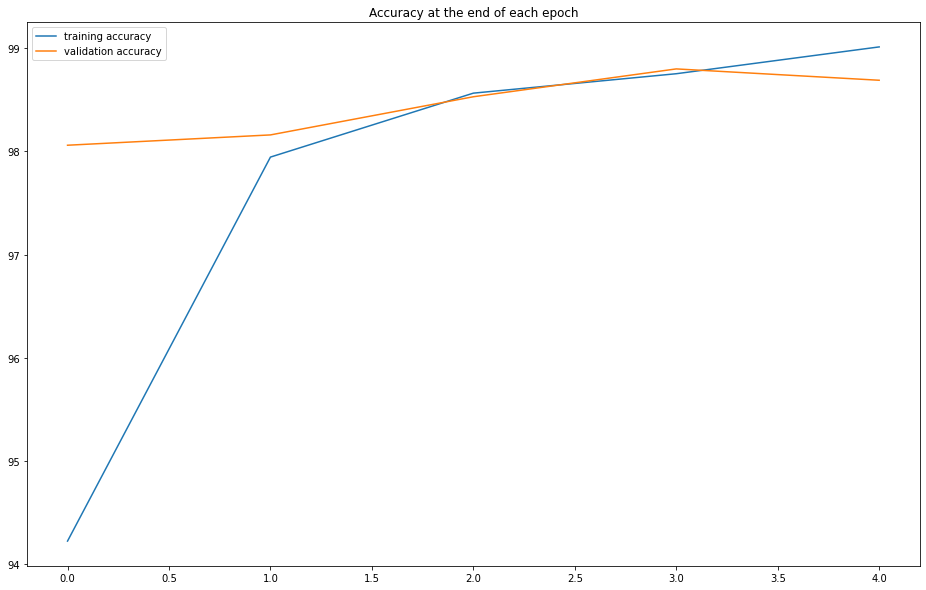

In [154]:
# 600 100 are batch
plt.figure(figsize=(16,10))
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [155]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [156]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9869/10000 =  98.690%


**confusion matrix**

In [157]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 973    0    5    0    1    2    3    0    4    0]
 [   0 1131    0    0    0    0    1    4    1    0]
 [   1    1 1018    1    0    0    0    6    1    0]
 [   0    0    0  998    0    6    0    1    1    0]
 [   0    0    1    0  973    0    2    1    1   17]
 [   0    1    0    3    0  879    1    0    0    3]
 [   4    2    1    0    4    2  950    0    0    0]
 [   2    0    5    1    0    1    0 1010    0    4]
 [   0    0    2    6    3    1    1    2  964   12]
 [   0    0    0    1    1    1    0    4    2  973]]


**The misses**

In [158]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

131

In [160]:
# Display the first 10 index positions
misses

array([  18,   62,  247,  264,  320,  359,  445,  448,  495,  583,  646,
        659,  684,  720,  813,  938,  939,  947,  966, 1014, 1021, 1033,
       1039, 1112, 1114, 1156, 1178, 1192, 1226, 1232, 1247, 1260, 1299,
       1364, 1393, 1414, 1500, 1520, 1522, 1527, 1549, 1569, 1621, 1681,
       1709, 1721, 1871, 1878, 1901, 1903, 2018, 2035, 2043, 2070, 2098,
       2130, 2186, 2189, 2195, 2293, 2406, 2426, 2462, 2488, 2597, 2654,
       2720, 2742, 2770, 2810, 2863, 2896, 2910, 2921, 2953, 3005, 3225,
       3316, 3369, 3422, 3520, 3534, 3558, 3601, 3662, 3762, 3808, 3850,
       3859, 3869, 3941, 4027, 4224, 4256, 4571, 4639, 4740, 4761, 4807,
       4823, 4874, 4956, 5937, 5955, 5973, 5997, 6532, 6571, 6576, 6597,
       6651, 6783, 7216, 7434, 7637, 7736, 7964, 8094, 8160, 8246, 8325,
       8382, 9497, 9530, 9642, 9664, 9701, 9729, 9770, 9839, 9982])

In [161]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [ 684  720  813  938  939  947  966 1014 1021 1033 1039 1112]
Label: [   7    5    9    3    2    8    9    6    7    8    7    4]
Guess: [   2    8    8    5    0    9    8    5    2    1    3    6]


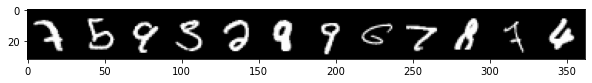

In [165]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

**Run a new image through the model**

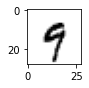

In [166]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [167]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9
